In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tsfresh
import os
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="ticks")

from tsfresh.feature_extraction.feature_calculators import *

In [3]:
np.random.seed(0)

In [4]:
# target_folder = './extracted/mwd/nopims/'
target_folder = '/home/sharifullina/thesis/datasets/extracted/mwd/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/nopims/'

In [5]:
wells = os.listdir(target_folder)
logs = [json.load(open(os.path.join(target_folder, wells[i]), 'r')) for i in range(len(wells))]

In [6]:
required_params = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA']

In [7]:
# соеденим все логи скважин в один большой pandas.DaraFrame
dataset_all = [pd.DataFrame(logs[i]['data'], columns=[x['name'] for x in logs[i]['curves']]) for i in range(len(logs))]
dataset = []
for df in dataset_all:
    dataset.append(df[required_params])
X_all = dataset[0]
for i in range(1, len(dataset)):
    X_all = pd.concat([X_all, dataset[i]], ignore_index = True)


In [8]:
len(X_all)

59261

Примеры различающихся скважин  
1.  X_all.iloc[0:256] X_all.iloc[256:512] и тд => таких 10 скважин
2.  добавление шума в данные => таких 10 скважин

Примеры схожих скважин
1.  X_all.iloc[0:256] X_all.iloc[10:266] и тд => таких 20 скважин

In [60]:
X_all[0 : 256]

,DEPTH,ROPA,HKLA,WOB,SPPA
0,2179.0,1.62,82.92,0.77,82.43
1,2180.0,0.54,82.33,1.89,70.87
2,2181.0,1.03,80.42,3.87,70.99
3,2182.0,1.29,80.56,3.73,74.51
4,2183.0,6.92,81.36,2.93,74.75
...,...,...,...,...,...
251,2430.0,24.26,77.35,2.79,288.19
252,2431.0,29.55,77.08,3.06,288.28
253,2432.0,24.33,77.35,2.79,288.48
254,2433.0,40.79,76.84,3.30,288.19


In [97]:
# в эти два списка запишем по 20 датафреймов схожих и различающихся скважин с размером окна 256
similar_wells = []

for i in range(0, 18400, 20):
    similar_wells.append(X_all[i : 256 + i])
# преобразуем лист в массив с размерностью [20, 256, 5]; 20 - количество скважин, 256 - размерность окна, 
#                                                   5 - количество столбцов = len(required_params)
similar_wells = np.dstack(similar_wells)
similar_wells = np.rollaxis(similar_wells, -1)


In [98]:
different_wells = []

for i in range(0, 256 * 230, 256):
    different_wells.append(X_all[i : 256 + i])
    different_wells.append(X_all[i : 256 + i] + np.random.normal(X_all[i : 256 + i].mean(),\
                                                                 X_all[i : 256 + i].std(), [256, 5]))
    different_wells.append(X_all[i : 256 + i] + np.random.normal(X_all[i : 256 + i].mean(), \
                                                                 X_all[i : 256 + i].std(), [256, 5]))
    different_wells.append(X_all[i : 256 + i] + np.random.normal(X_all[i : 256 + i].mean(),\
                                                                 X_all[i : 256 + i].std(), [256, 5]))
    
different_wells = np.dstack(different_wells)
different_wells = np.rollaxis(different_wells, -1)

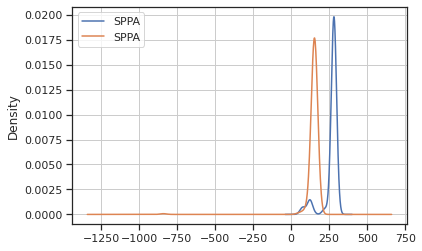

In [99]:
# разпредедление для первых двух одинаковых скважин
pd.concat([pd.DataFrame(similar_wells[0], columns=required_params), \
           pd.DataFrame(similar_wells[200], columns=required_params)], axis = 1).SPPA.plot.kde()
plt.grid()
plt.show()

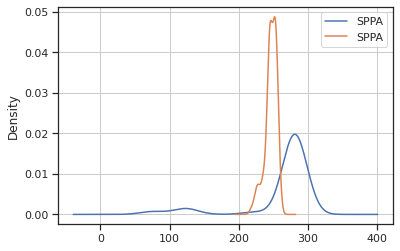

In [100]:
pd.concat([pd.DataFrame(different_wells[0], columns=required_params), \
           pd.DataFrame(different_wells[200], columns=required_params)], axis = 1).SPPA.plot.kde()
plt.grid()
plt.show()

In [101]:
# выпишем все функции библиотеки которые нам нужны
listOfFunctions = [f for f in tsfresh.feature_extraction.feature_calculators.__dict__.values()
                   if hasattr(f,'__call__')]

listOfFunctions = listOfFunctions[21:] # первые 21 нам не нужны

In [102]:
# в needed_actions запишем только те функции, которые принимают на вход один позиционный оргумент
needed_actions = []
for i in range(len(listOfFunctions)):
    if listOfFunctions[i].__code__.co_argcount == 1:
        needed_actions.append(listOfFunctions[i])

needed_actions = needed_actions[4:] # первые 4 функции возвращают только True/False поэтому их не рассматриваем

одинаковые скважины

In [103]:
# ключами словаря similar_metric будут названия функций
# элементами ключей будут значения функций для каждой из 20 скважин для каждого элемента из 5 элеметов списка required_params
# т.е. [[shape=20], [shape=20], [shape=20], [shape=20], [shape=20]]

similar_metric = {}

for k in range(len(needed_actions)):
    if str(needed_actions[k]) not in similar_metric:
        similar_metric[str(needed_actions[k])] = []

one_req_param = []
for k in range(len(needed_actions)):
    for i in range(len(required_params)):
        for j in range(different_wells.shape[0]):
            one_req_param.append(needed_actions[k].__call__(similar_wells[j][:, i]))
        similar_metric[str(needed_actions[k])].append(one_req_param)
        one_req_param = []
        

In [104]:
different_metric = {}

for k in range(len(needed_actions)):
    if str(needed_actions[k]) not in different_metric:
        different_metric[str(needed_actions[k])] = []

one_req_param = []
for k in range(len(needed_actions)):
    for i in range(len(required_params)):
        for j in range(different_wells.shape[0]):
            one_req_param.append(needed_actions[k].__call__(different_wells[j][:, i]))
        different_metric[str(needed_actions[k])].append(one_req_param)
        one_req_param = []

отрисовка

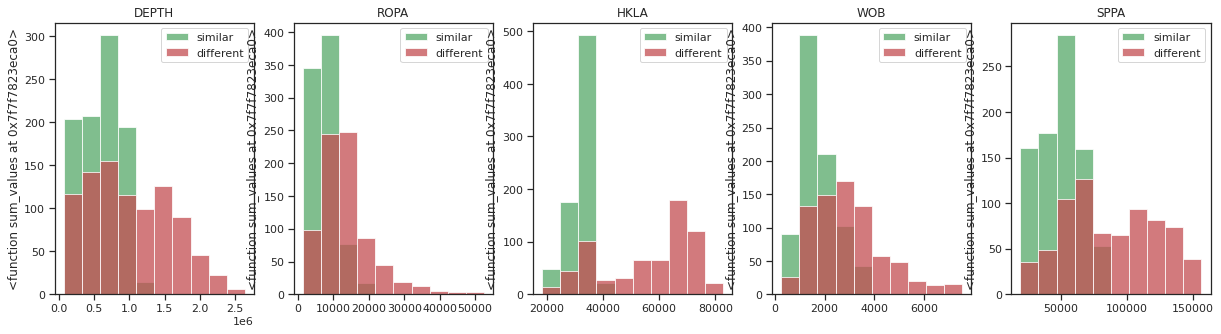

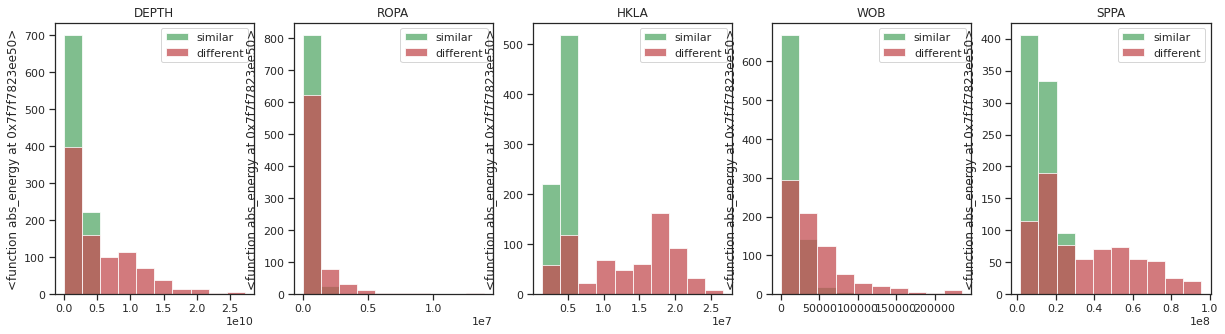

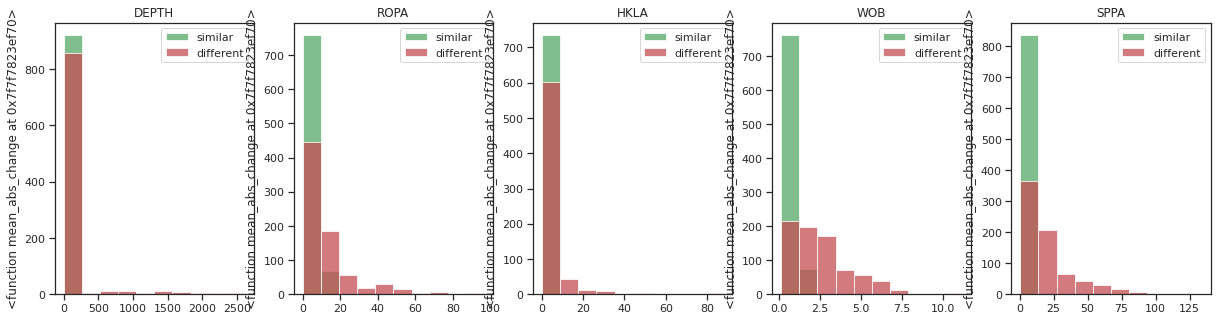

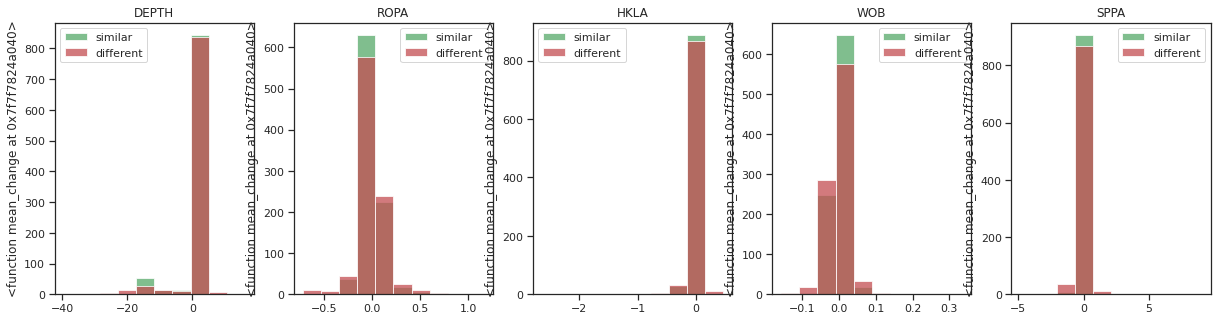

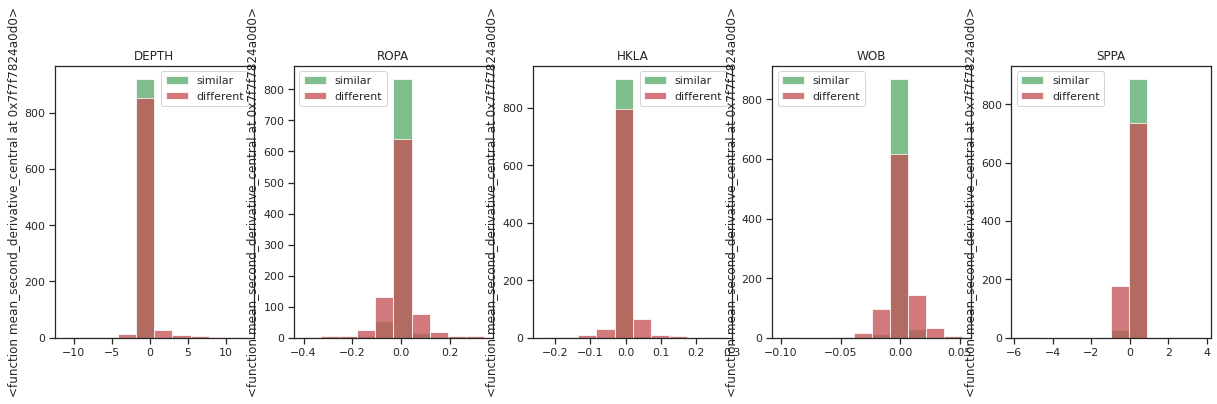

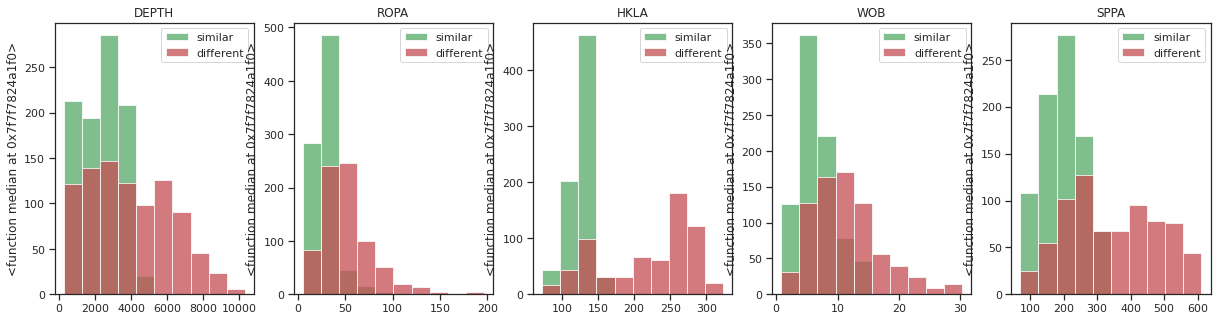

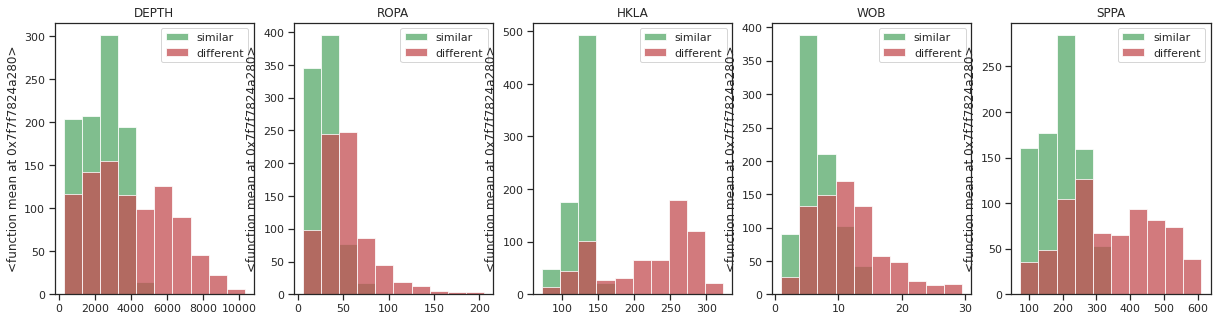

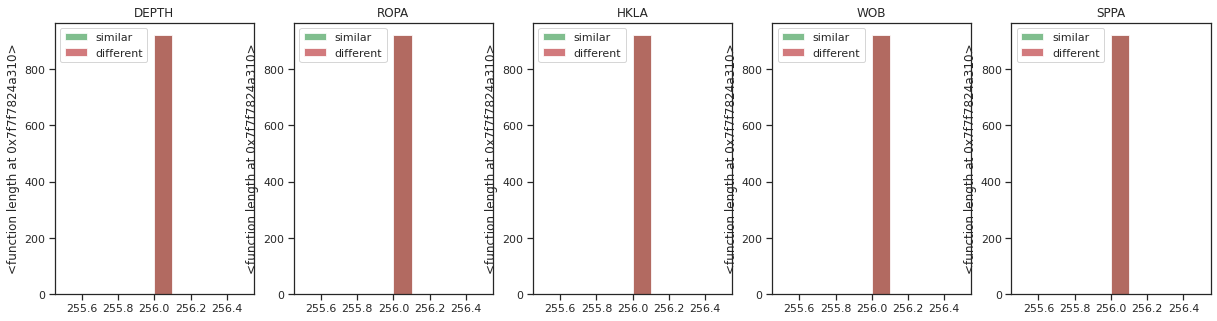

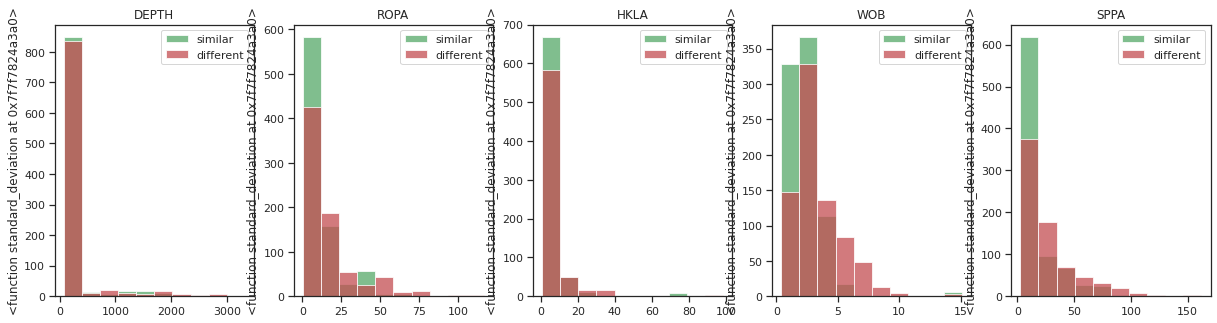

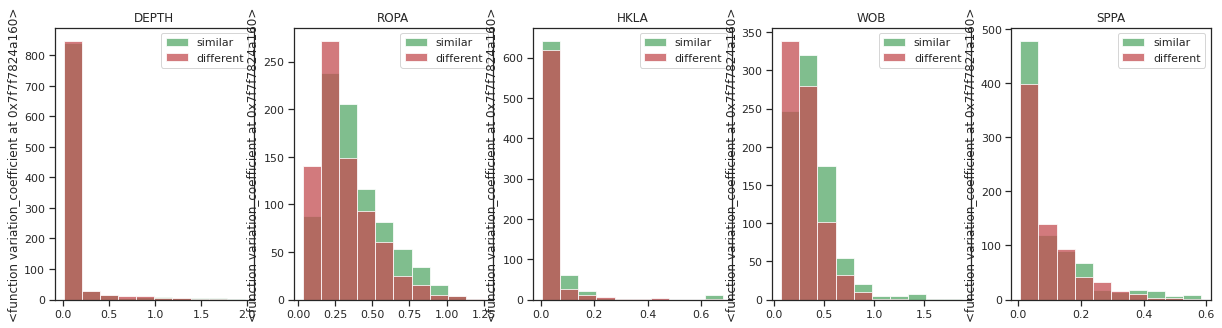

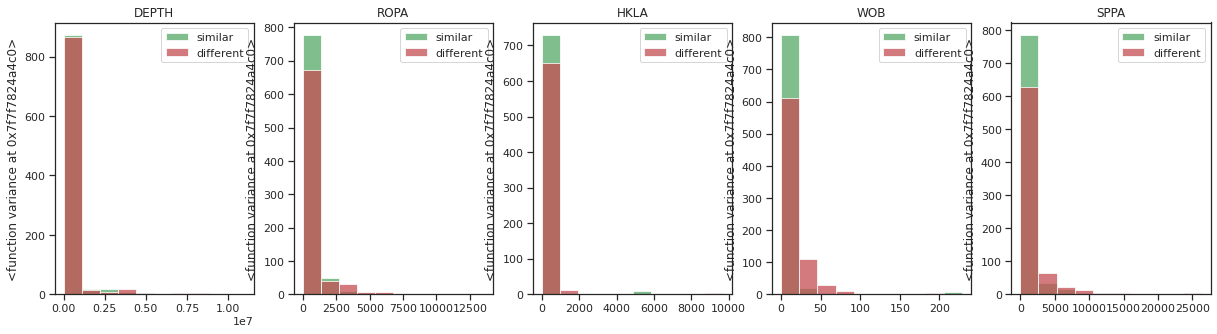

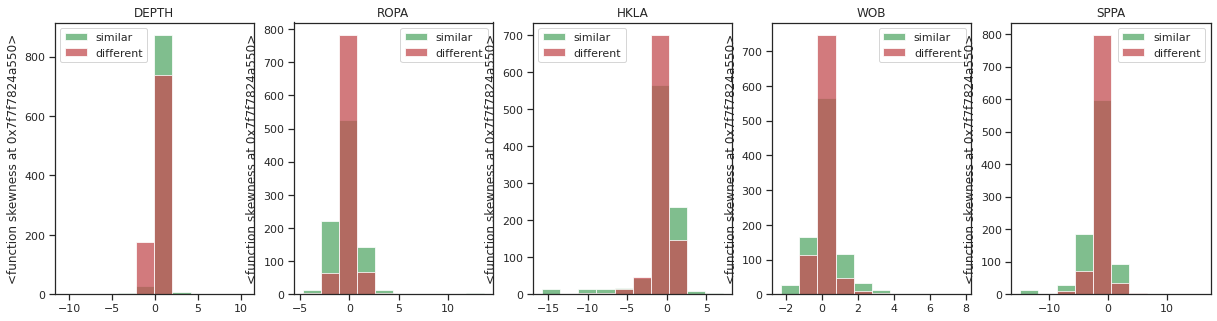

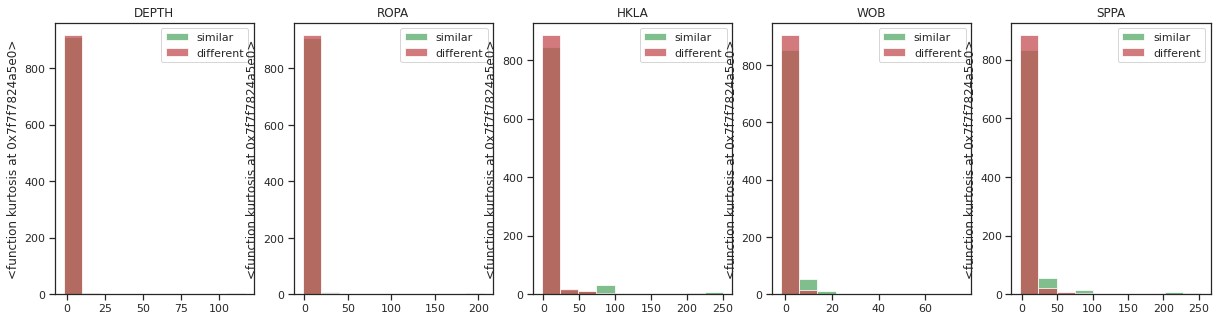

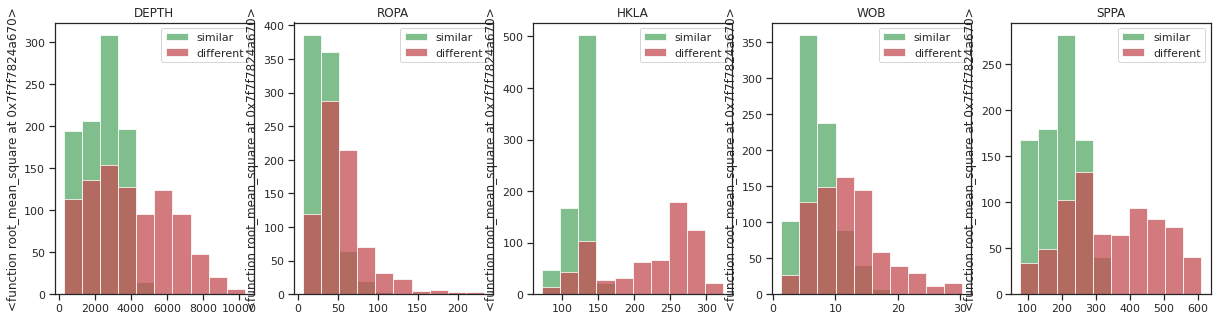

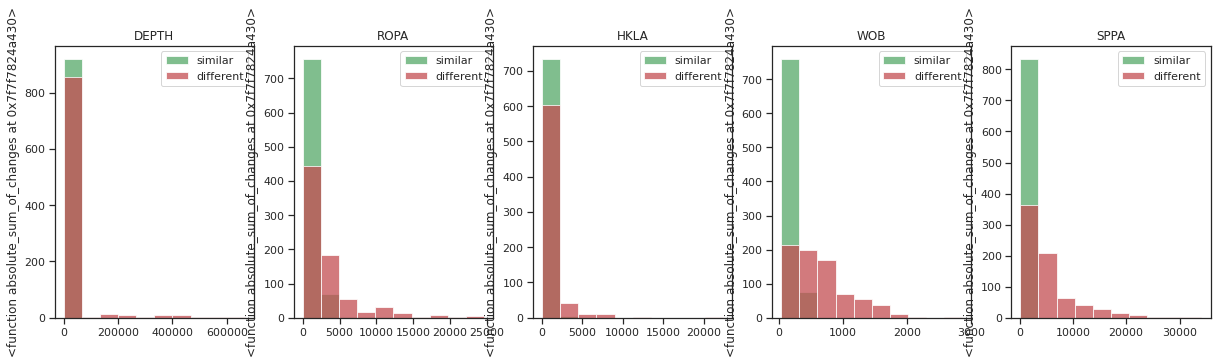

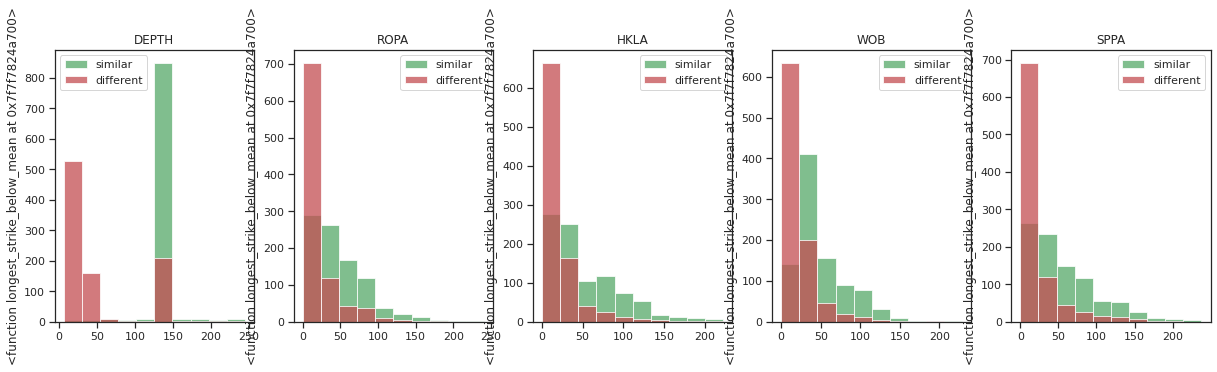

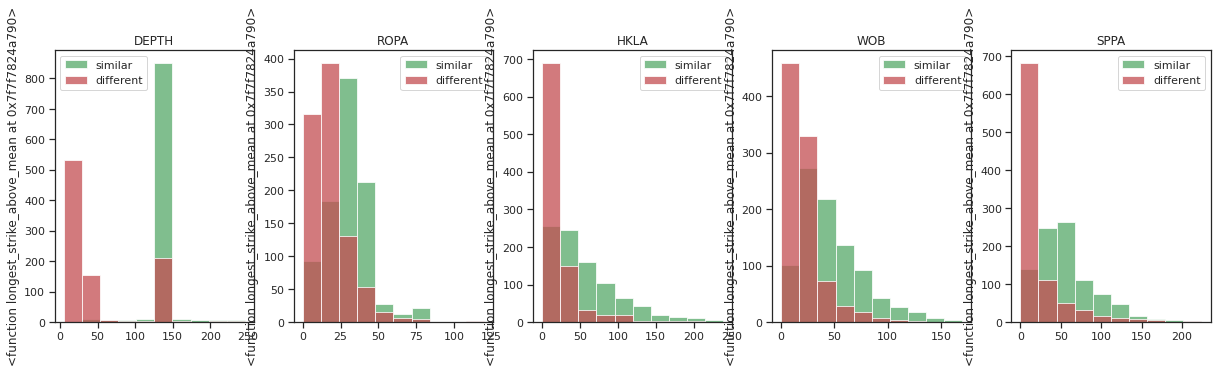

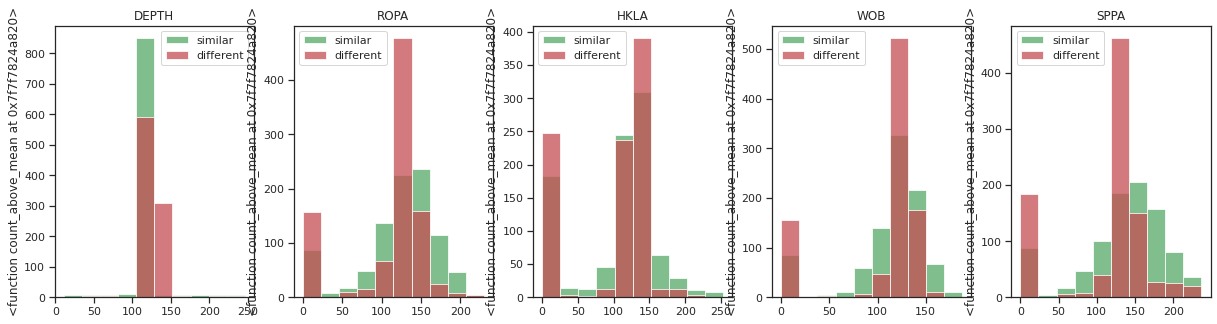

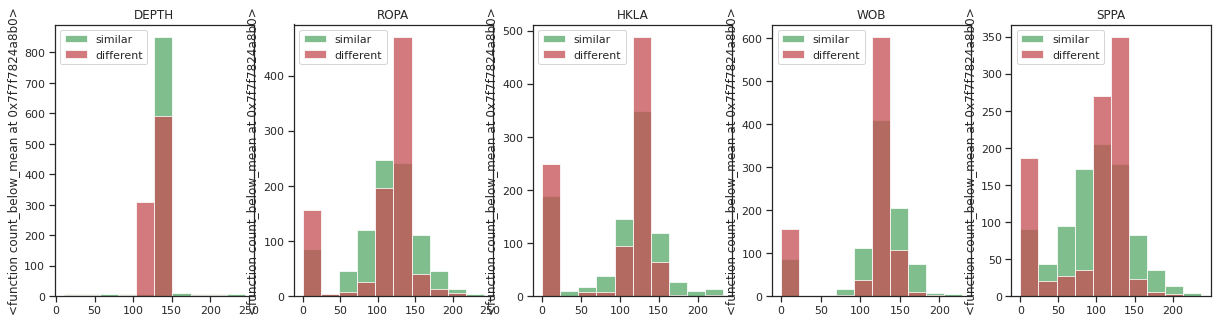

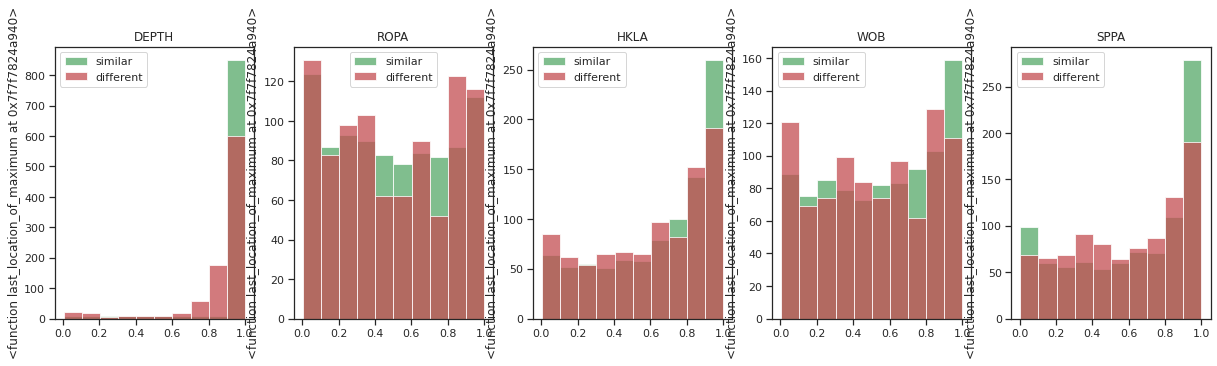

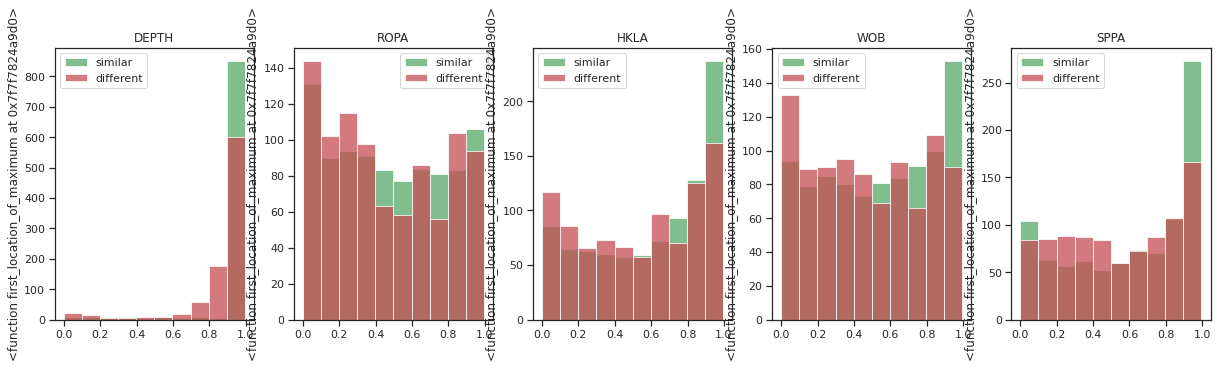

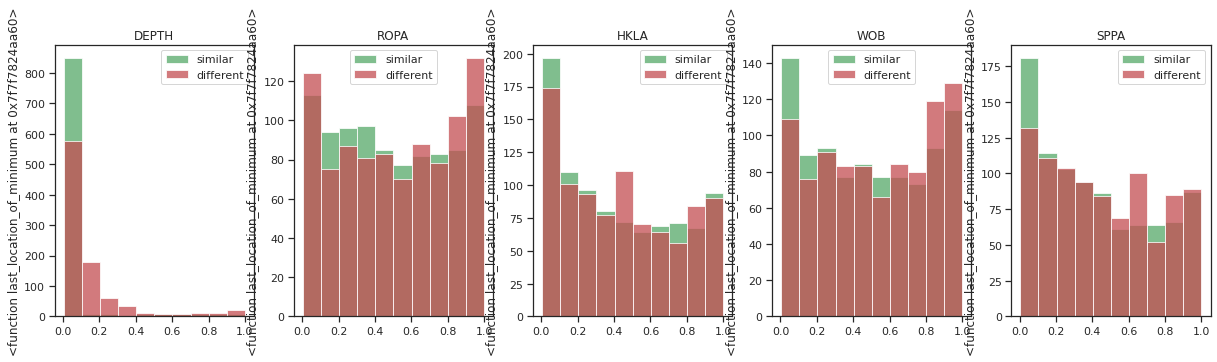

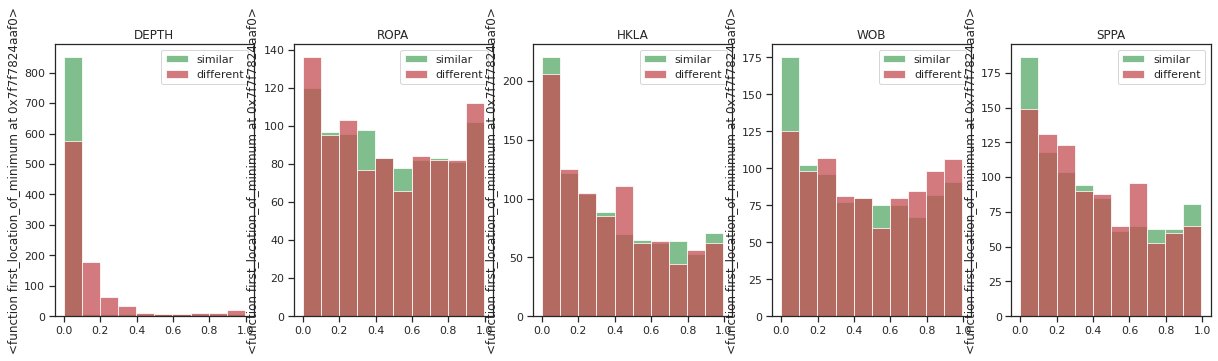

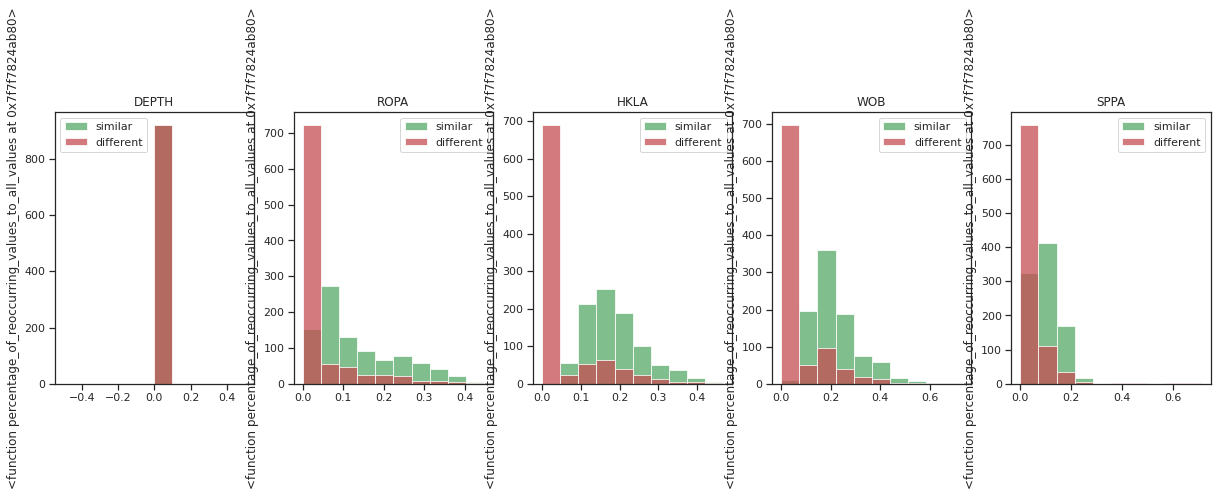

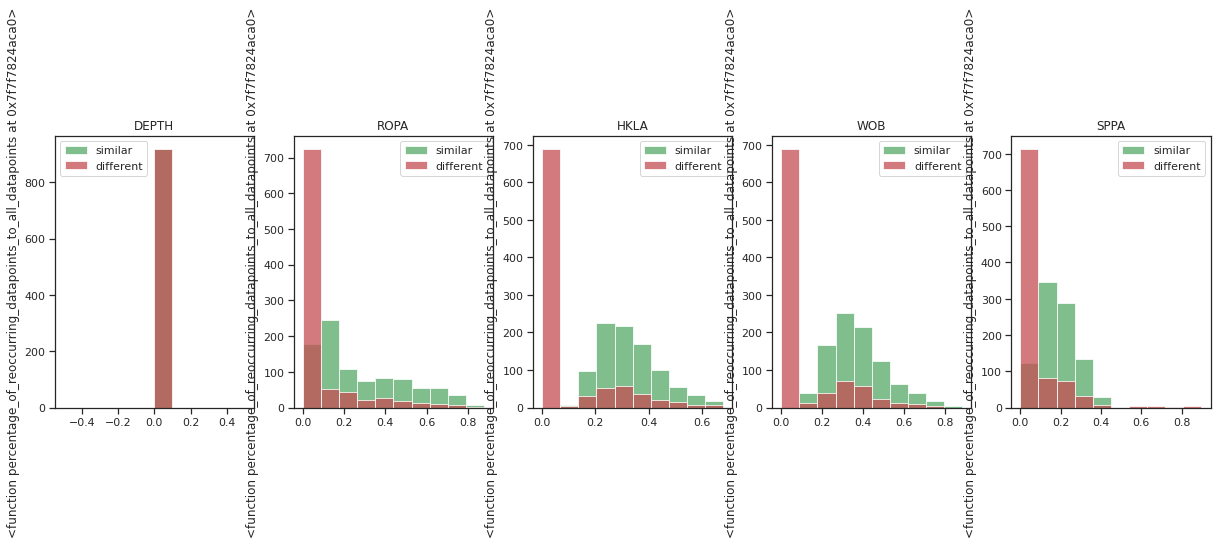

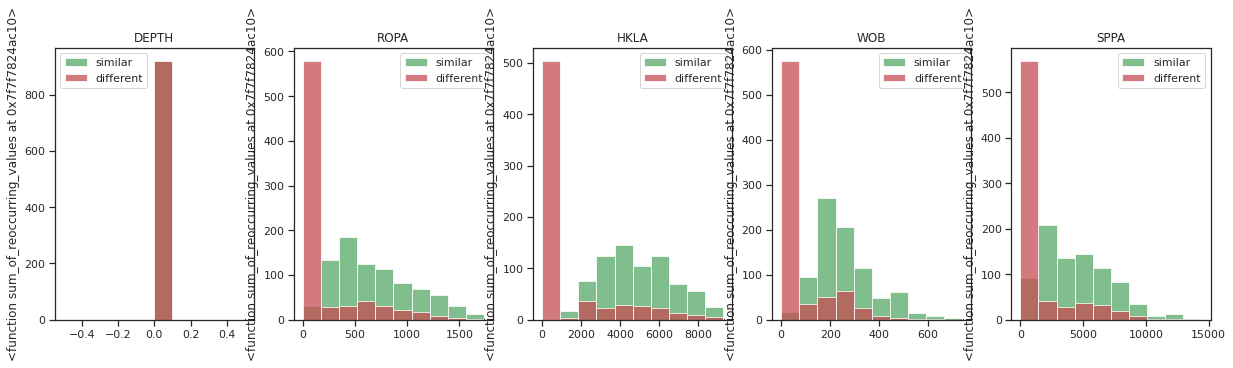

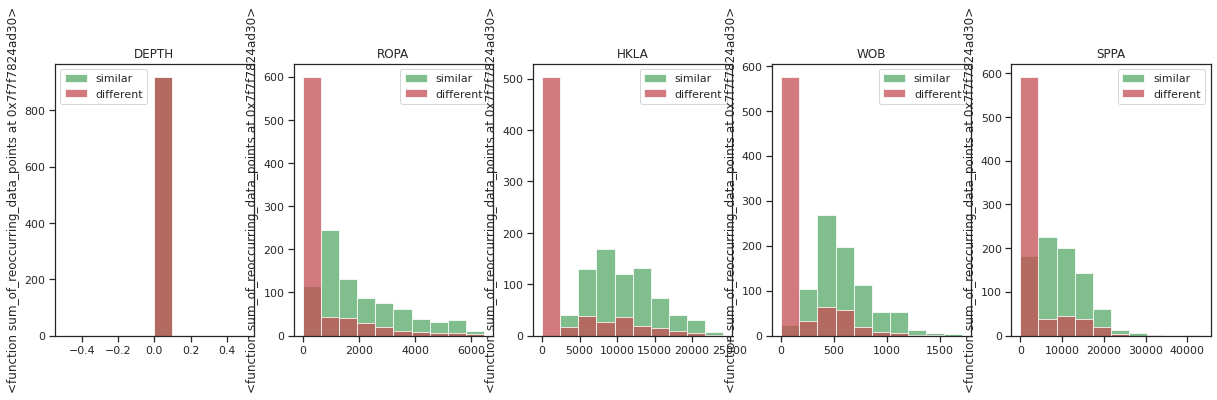

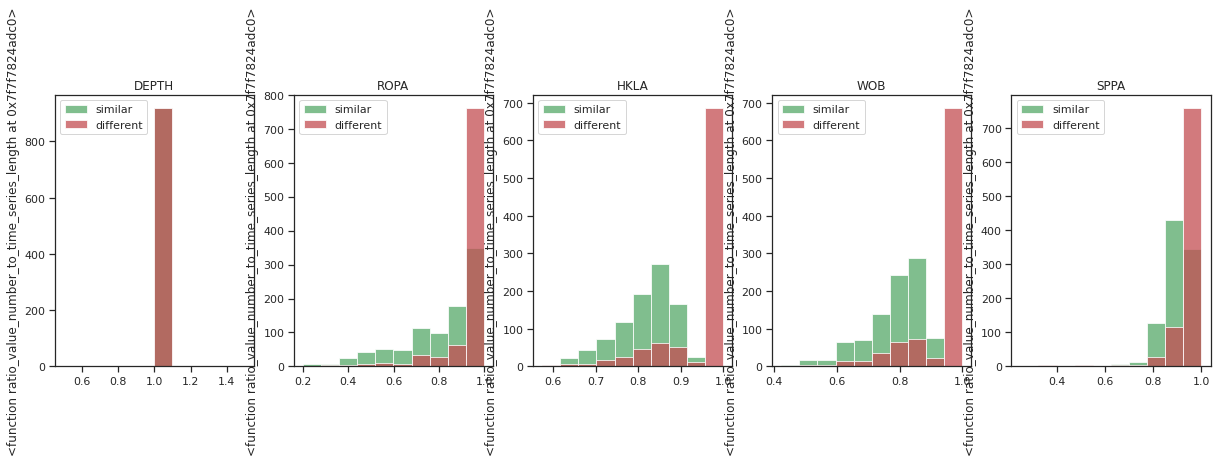

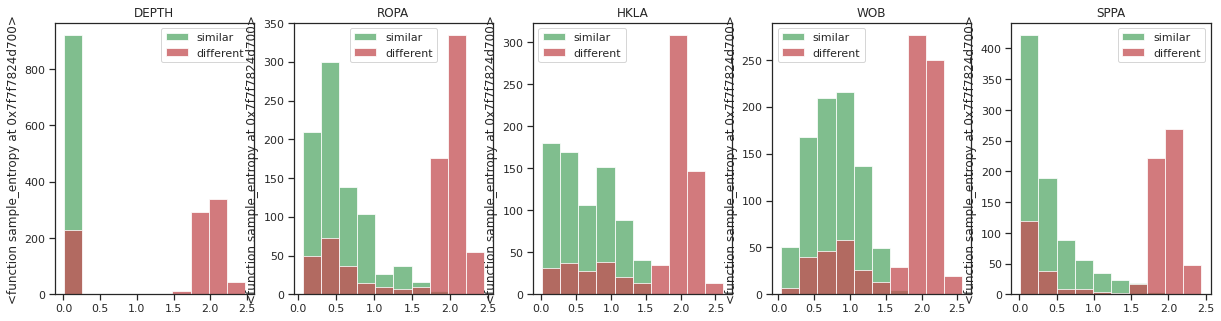

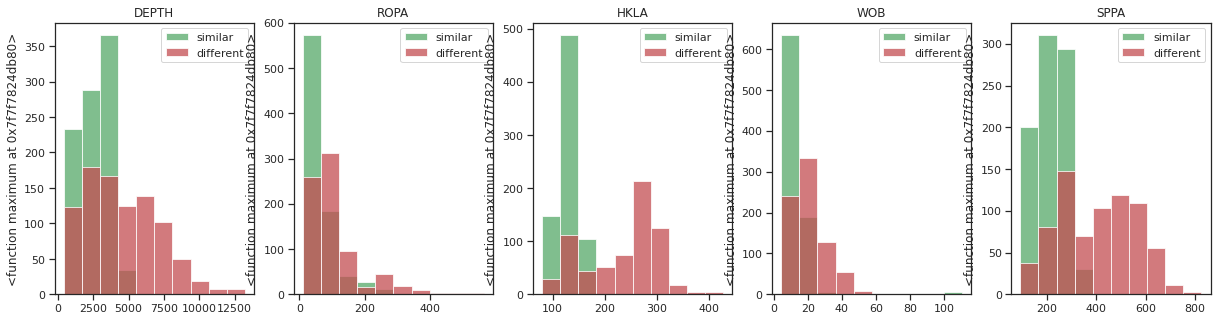

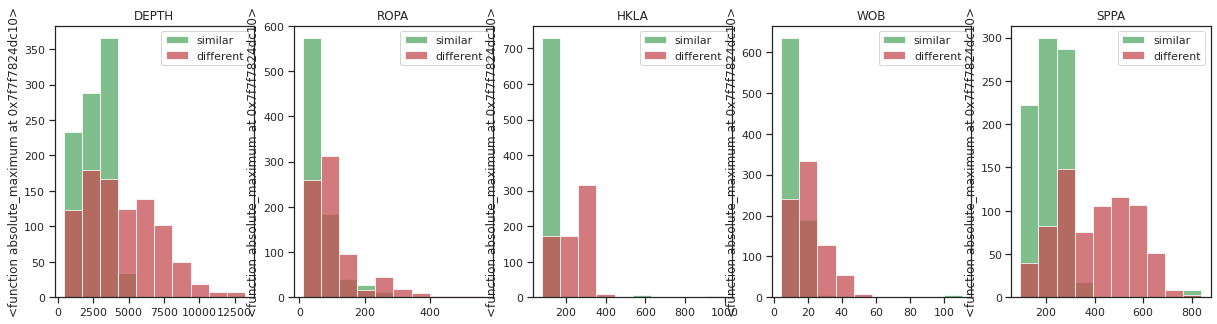

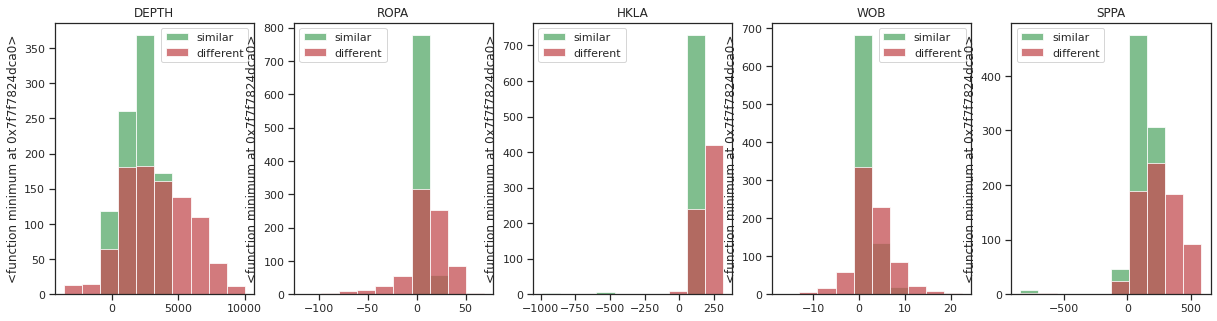

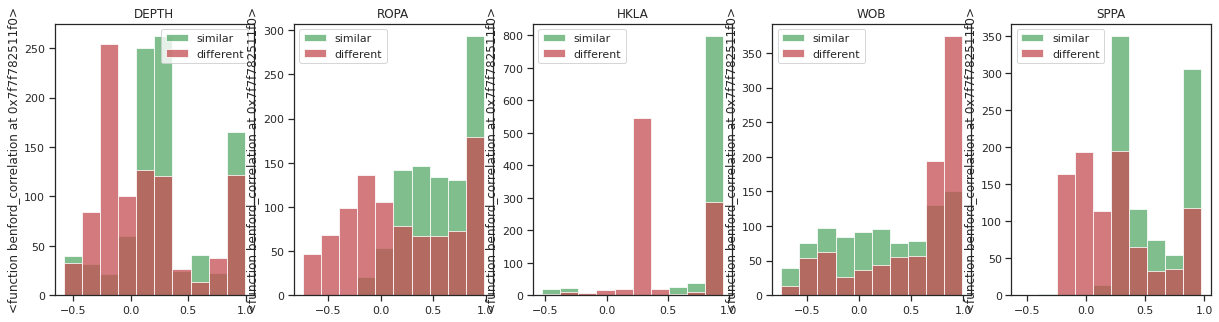

In [105]:
import scipy.stats as stats


for j in range(len(similar_metric)):
    plt.figure(figsize=(25, 5))
    for i in range(1, 6):
        plt.subplot(1, 6, i)
        plt.title(required_params[i - 1])
        plt.hist(similar_metric[str(needed_actions[j])][i - 1], \
                 bins = 10, range=[min(min(similar_metric[str(needed_actions[j])][i - 1]), min(different_metric[str(needed_actions[j])][i - 1])), \
                                   max(max(similar_metric[str(needed_actions[j])][i - 1]), max(different_metric[str(needed_actions[j])][i - 1]))],\
                 facecolor='g', alpha=0.75, label = 'similar')
        plt.hist(different_metric[str(needed_actions[j])][i - 1],\
                 bins = 10, range=[min(min(similar_metric[str(needed_actions[j])][i - 1]), min(different_metric[str(needed_actions[j])][i - 1])),\
                                   max(max(similar_metric[str(needed_actions[j])][i - 1]), max(different_metric[str(needed_actions[j])][i - 1]))],\
                 facecolor='r', alpha=0.75, label = 'different')


#         df = pd.DataFrame({
#             'similar_metric': similar_metric[str(needed_actions[j])][i - 1],
#             'different_metric': different_metric[str(needed_actions[j])][i - 1],
#         })
#         df.plot.kde()
        
        plt.legend()
        plt.ylabel(str(needed_actions[j]))
plt.show()      

На рассмотрение
1. sum_values  
2. abs_energy
3. mean_abs_change  
4. median  
5. mean  
6. root_mean_square  
7. absolute_sum_of_changes  
8. longest_strike_below_mean  
9. longest_strike_above_mean  
10. count_above_mean
11. count_below_mean  
12. percentage_of_reoccurring_values_to_all_values
13. sample_entropy  

### sum_values
Calculates the sum over the time series values

In [178]:
print(tsfresh.feature_extraction.feature_calculators.sum_values(similar_wells[0, :, 1]))
print(similar_wells[0, :, 1].sum())

7257.599999999999
7257.599999999999


### abs_energy
$$
\sum_{i=1}^{n}x_i^2
$$


In [177]:
print(tsfresh.feature_extraction.feature_calculators.abs_energy(similar_wells[0, :, 1]))
print(sum(similar_wells[0, :, 1][i] ** 2 for i in range(256)))

246876.2756
246876.27559999996


### mean_abs_change
$$
\frac{1}{n-1}\sum_{i=1}^{n - 1}|x_{i+1} - x_i|
$$

In [167]:
print(tsfresh.feature_extraction.feature_calculators.mean_abs_change(similar_wells[0, :, 1]))
summ = 0
for i in range(len(similar_wells[0, :, 1]) - 1):
    summ += abs(similar_wells[0, :, 1][i + 1] - similar_wells[0, :, 1][i])
print((1 / (len(similar_wells[0, :, 1]) - 1)) * summ)

6.621764705882353
6.621764705882351


### median

In [139]:
print(tsfresh.feature_extraction.feature_calculators.median(similar_wells[0, :, 1]))
print(median(similar_wells[0, :, 1]))

30.15
30.15


### mean

In [140]:
print(tsfresh.feature_extraction.feature_calculators.mean(similar_wells[0, :, 1]))
print(mean(similar_wells[0, :, 1]))

28.349999999999998
28.349999999999998


### root_mean_square

In [169]:
print(tsfresh.feature_extraction.feature_calculators.root_mean_square(similar_wells[0, :, 1]))
print((sum(similar_wells[0, :, 1] ** 2) / len(similar_wells[0, :, 1])) ** 0.5)

31.054153531572872
31.054153531572872


### absolute_sum_of_changes
$$
\sum_{i=1}^{n - 1}|x_{i-1} - x_i|
$$

In [171]:
print(tsfresh.feature_extraction.feature_calculators.absolute_sum_of_changes(similar_wells[0, :, 1]))
summ = 0
for i in range(len(similar_wells[0, :, 1]) - 1):
    summ += abs(similar_wells[0, :, 1][i + 1] - similar_wells[0, :, 1][i])
print(summ)

1688.5500000000002
1688.5499999999997


### longest_strike_below_mean
Returns the length of the longest consecutive subsequence in x that is smaller than the mean of x

In [173]:
print(tsfresh.feature_extraction.feature_calculators.longest_strike_below_mean(similar_wells[0, :, 1]))

28


### longest_strike_above_mean
Returns the length of the longest consecutive subsequence in x that is smaller than the mean of x

In [174]:
# longest_strike_above_mean
print(tsfresh.feature_extraction.feature_calculators.longest_strike_above_mean(similar_wells[0, :, 1]))

21


### count_above_mean
Returns the number of values in x that are higher than the mean of x

In [176]:
print(tsfresh.feature_extraction.feature_calculators.count_above_mean(similar_wells[0, :, 1]))

145


### percentage_of_reoccurring_values_to_all_values
len(different values occurring more than once) / len(different values)

In [179]:
print(tsfresh.feature_extraction.feature_calculators.percentage_of_reoccurring_values_to_all_values(similar_wells[0, :, 1]))

0.05785123966942149


### sample_entropy
measure of complexity
https://en.wikipedia.org/wiki/Sample_entropy

In [180]:
print(tsfresh.feature_extraction.feature_calculators.sample_entropy(similar_wells[0, :, 1]))

1.2095571826198368


## Метрики которые могли бы подойти: 
1) mean  
2) median  
3) mean_abs_change  
4) absolute_sum_of_changes  
5) count_above_mean  
